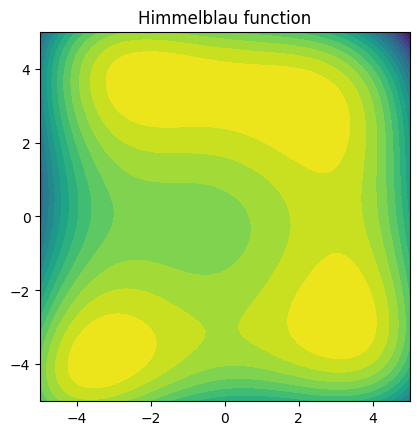

In [1]:
import matplotlib.pyplot as plt
import torch


def himmelblau(x: torch.Tensor):
    return -((x[:, 0] ** 2 + x[:, 1] - 11) ** 2 + (x[:, 0] + x[:, 1] ** 2 - 7) ** 2)


bounds = torch.tensor([[-5.0, -5.0], [5.0, 5.0]], dtype=torch.float64)
x = torch.linspace(bounds[0, 0], bounds[1, 0], 64)
y = torch.linspace(bounds[0, 1], bounds[1, 1], 64)
xy = torch.cartesian_prod(x, y)
z = himmelblau(xy).view(64, 64)

plt.contourf(x, y, z, levels=20)
plt.title("Himmelblau function")
plt.gca().set_aspect("equal")

In [2]:
xy

tensor([[-5.0000, -5.0000],
        [-5.0000, -4.8413],
        [-5.0000, -4.6825],
        ...,
        [ 5.0000,  4.6825],
        [ 5.0000,  4.8413],
        [ 5.0000,  5.0000]])

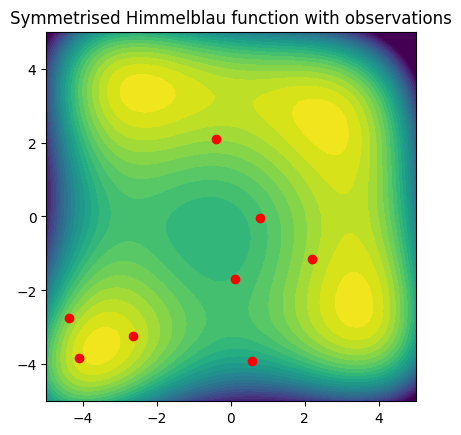

In [3]:
from torch.distributions.uniform import Uniform

torch.manual_seed(1)


def symmetrised(f):
    def g(x):
        return 0.5 * (f(x) + f(torch.flip(x, [-1])))

    return g


def objective(x):
    return symmetrised(himmelblau)(x)


plt.figure()
# Function
plt.contourf(
    x,
    y,
    objective(xy).view(64, 64),
    levels=50,
    vmin=-500,
    vmax=0,
)

# Observations
n = 8
x_train = Uniform(bounds[0, 0], bounds[1, 0]).sample((n, 2))
y_train = objective(x_train)
x_train = x_train.to(dtype=torch.float64)
y_train = y_train.to(dtype=torch.float64)

plt.scatter(x_train[:, 0], x_train[:, 1], color="r")
plt.title("Symmetrised Himmelblau function with observations")
plt.gca().set_aspect("equal")

/home/theo/documents/invariantkernels/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


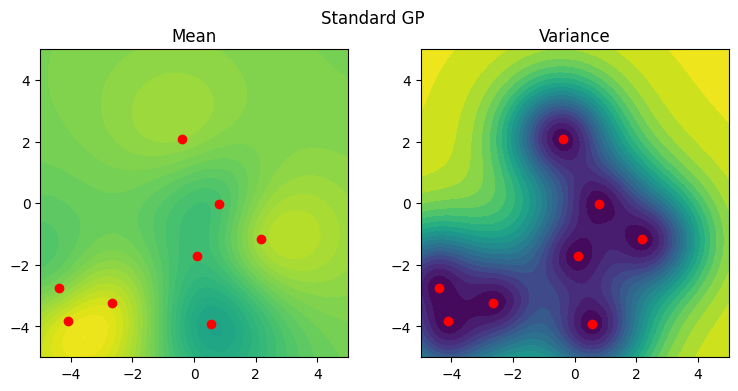

In [ ]:
from botorch.models import SingleTaskGP
from botorch.models.transforms import Standardize, Normalize
from gpytorch.kernels import MaternKernel, ScaleKernel


kernel = ScaleKernel(
    base_kernel=MaternKernel(nu=2.5),
    outputscale=500,
)
kernel.base_kernel.raw_lengthscale = torch.nn.Parameter(torch.tensor([2.0]))

gp = SingleTaskGP(
    x_train,
    y_train.unsqueeze(-1),
    covar_module=kernel,
)
with torch.no_grad():
    posterior = gp.posterior(xy)

plt.figure(figsize=(9, 4))
plt.subplot(121)
plt.contourf(
    x,
    y,
    posterior.mean.view(64, 64).T,
    levels=20,
    vmin=-500,
    vmax=0,
)

plt.scatter(x_train[:, 0], x_train[:, 1], color="r")
plt.title("Mean")
plt.gca().set_aspect("equal")
plt.subplot(122)
plt.contourf(x, y, posterior.variance.view(64, 64).T, levels=20)
plt.scatter(x_train[:, 0], x_train[:, 1], color="r")
plt.title("Variance")
plt.suptitle("Standard GP")
plt.gca().set_aspect("equal")
plt.show()

The original invariant kernel method:

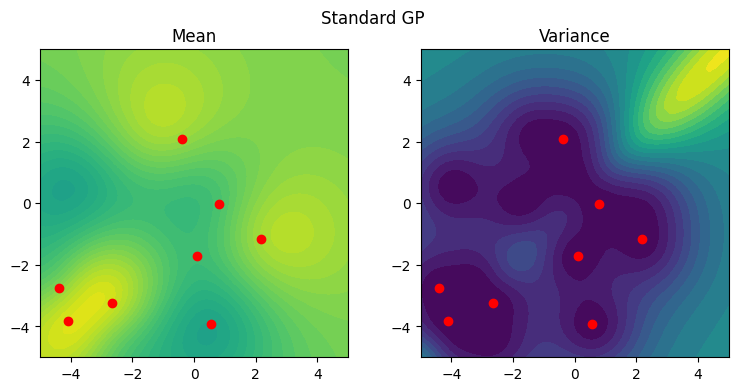

In [13]:
from invariantkernels import (
    permutation_group,
    GroupInvariantKernel,
)


invariant_gp = SingleTaskGP(
    x_train,
    torch.unsqueeze(y_train, -1),
    covar_module=GroupInvariantKernel(
        base_kernel=kernel,
        transformations=permutation_group,
        isotropic=True,
    ),
)

with torch.no_grad():
    posterior = invariant_gp.posterior(xy)

plt.figure(figsize=(9, 4))
plt.subplot(121)
plt.contourf(
    x,
    y,
    posterior.mean.view(64, 64).T,
    levels=20,
    vmin=-500,
    vmax=0,
)

plt.scatter(x_train[:, 0], x_train[:, 1], color="r")
plt.title("Mean")
plt.gca().set_aspect("equal")
plt.subplot(122)
plt.contourf(x, y, posterior.variance.view(64, 64).T, levels=20)
plt.scatter(x_train[:, 0], x_train[:, 1], color="r")
plt.title("Variance")
plt.suptitle("Standard GP")
plt.gca().set_aspect("equal")
plt.show()

Normalized invariant kernel method:

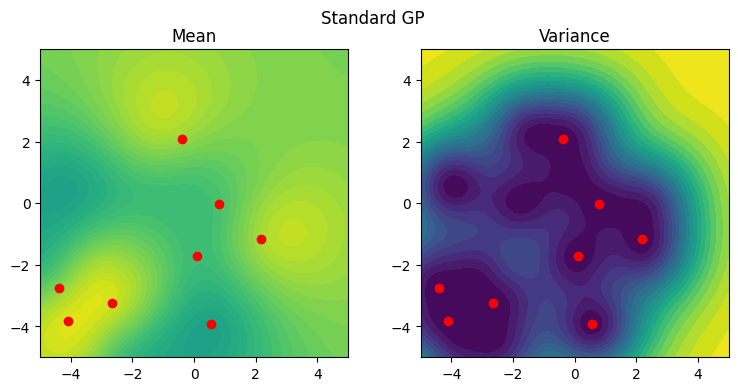

In [14]:
from invariantkernels import (
    permutation_group,
    GroupInvariantKernel,
)

normalized_invariant_gp = SingleTaskGP(
    x_train,
    torch.unsqueeze(y_train, -1),
    covar_module=GroupInvariantKernel(
        base_kernel=kernel,
        transformations=permutation_group,
        isotropic=True,
        normalised=True,
    ),
)

with torch.no_grad():
    posterior = normalized_invariant_gp.posterior(xy)

plt.figure(figsize=(9, 4))
plt.subplot(121)
plt.contourf(
    x,
    y,
    posterior.mean.view(64, 64).T,
    levels=20,
    vmin=-500,
    vmax=0,
)

plt.scatter(x_train[:, 0], x_train[:, 1], color="r")
plt.title("Mean")
plt.gca().set_aspect("equal")
plt.subplot(122)
plt.contourf(x, y, posterior.variance.view(64, 64).T, levels=20)
plt.scatter(x_train[:, 0], x_train[:, 1], color="r")
plt.title("Variance")
plt.suptitle("Standard GP")
plt.gca().set_aspect("equal")
plt.show()